In [4]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11501568/11490434 [==============================] - 1s 0us/step


In [32]:
print(x_train.shape, y_train.shape)

((60000, 28, 28, 1), (60000,))


In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [7]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [8]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [9]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [10]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [13]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.134675204754, Accuracy: 95.9800033569, Test Loss: 0.0630413144827, Test Accuracy: 97.9499969482
Epoch 2, Loss: 0.043342422694, Accuracy: 98.6199951172, Test Loss: 0.0614176504314, Test Accuracy: 97.9300003052
Epoch 3, Loss: 0.0229823887348, Accuracy: 99.2383346558, Test Loss: 0.0537048242986, Test Accuracy: 98.3899993896
Epoch 4, Loss: 0.014112142846, Accuracy: 99.5033340454, Test Loss: 0.0610818266869, Test Accuracy: 98.1599960327
Epoch 5, Loss: 0.0096153896302, Accuracy: 99.6866607666

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [15]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


In [34]:
print(train_images.shape, train_labels.shape)

((60000, 28, 28), (60000,))


In [52]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Flatten, Dense, Activation
def relu6(x):
    return keras.backend.relu(x, max_value=6)
model = keras.Sequential([
    Conv2D(32, 3, activation='relu',input_shape=[28,28,1]),
    DepthwiseConv2D(3, activation='relu'),
    BatchNormalization(),
    Activation(relu6),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10)
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build()

In [54]:
model.fit(x_train, y_train, epochs=3)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 248us/sample - loss: 0.1024 - accuracy: 0.9685
Epoch 2/10
60000/60000 [==============================] - 15s 243us/sample - loss: 0.0350 - accuracy: 0.9888
Epoch 3/10
60000/60000 [==============================] - 15s 244us/sample - loss: 0.0204 - accuracy: 0.9934
Epoch 4/10
60000/60000 [==============================] - 15s 244us/sample - loss: 0.0137 - accuracy: 0.9954
Epoch 5/10
60000/60000 [==============================] - 15s 244us/sample - loss: 0.0107 - accuracy: 0.9966
Epoch 6/10
60000/60000 [==============================] - 15s 245us/sample - loss: 0.0071 - accuracy: 0.9978
Epoch 7/10
60000/60000 [==============================] - 15s 252us/sample - loss: 0.0080 - accuracy: 0.9975
Epoch 8/10
60000/60000 [==============================] - 15s 245us/sample - loss: 0.0072 - accuracy: 0.9978
Epoch 9/10
60000/60000 [==============================] - 14s 239us/sample - loss: 0.0057 - accuracy: 0.9

In [55]:
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
depthwise_conv2d_6 (Depthwis (None, 24, 24, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dense_25 (Dense)             (None, 10)              

In [62]:
import json
with open("/home/a/eg_dataset.json", 'rb') as handle:
    dataset = json.load(handle)
    

dataset_sz = len(dataset)

print("Size dataset: {}".format(dataset_sz))

Size dataset: 2927


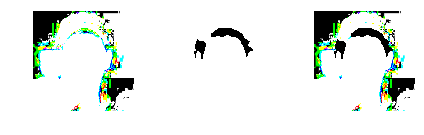

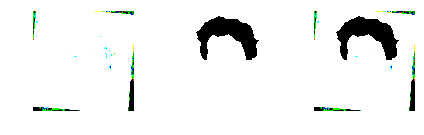

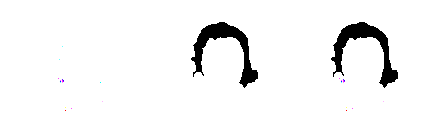

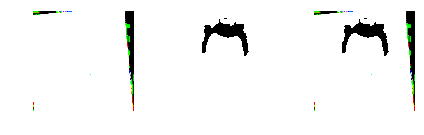

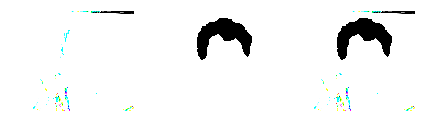

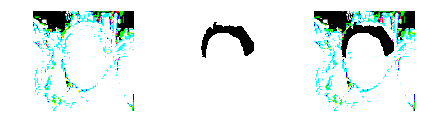

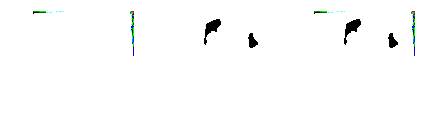

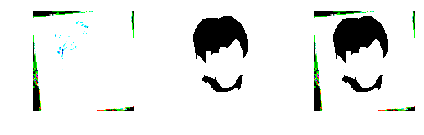

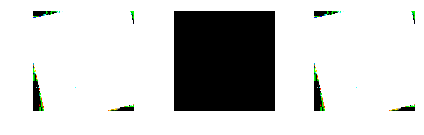

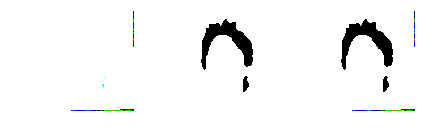

In [67]:


def read_mask_mat(mat_fname, mask_sz):
    """
    extract mask as a binary image array
        :mat_fname: str
        :mask_sz: tuple
    """
    h = tf.io.read_file(mat_fname)
    mat = tf.image.decode_jpeg(h, channels=3)
    #mask = mat["mask"]
    #mask = mask.astype( np.float32 )
    mask = mat
    mask_rsz = tf.image.resize(mask, mask_sz)
    #print(mask_rsz.shape)
    m = mask_rsz[:,:,0] < 1
    #m = m.astype("uint8")
    #m = m *255
    mask_rsz = m
    #mask_rsz[:,:,1] = m
    mask_rsz = np.expand_dims(mask_rsz, axis=2)
    return mask_rsz


def read_image_file(img_fname, crop, img_input_sz):
    """
    read raw image, resize and output array
    """
    #bgr = cv2.imread( img_fname )
    h = tf.io.read_file(img_fname)
    bgr = tf.image.decode_jpeg(h, channels=3)
    rgb = bgr[:, :, ::-1]
    if np.sum(crop) != 0: #image must be cropped
        assert len(crop)==4, "crop specs list must be of length 4"
        yi, yf, xi, xf = crop
        rgb = rgb[yi:yf, xi:xf, :]
    
    rgb_rsz = tf.image.resize(rgb, (600, 800))
    img_rsz = tf.image.resize(rgb_rsz, img_input_sz)
    return img_rsz


examples_id = np.random.choice(range(dataset_sz), 10)

mask_sz, img_input_sz = (224, 224), (224, 224) # The model takes images of that size

for idx in examples_id:
    example = dataset[idx]
    mask = read_mask_mat(example["mask"], mask_sz)
    img = read_image_file(example["img"], example["crop"], img_input_sz)
    combo = mask * img
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img)
    ax[1].imshow(mask[:,:,0], cmap="gray")
    ax[2].imshow(combo)
    ax[0].axis("off"), ax[1].axis("off"), ax[2].axis("off")
    plt.tight_layout()
    plt.show()